In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from datetime import datetime, timedelta
from pytrends.request import TrendReq
import yfinance as yf

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
ori_tweets_df = pd.read_csv('data/tweets_clean.csv')
ori_share_price_df = pd.read_csv('data/share_price.csv')

In [3]:
clean_tweets_df = ori_tweets_df.copy()
clean_tweets_df = clean_tweets_df.drop_duplicates()
clean_tweets_df.columns = ['timestamp', 'content', 'like', 'retweet', 'comment']
clean_tweets_df['date'] = pd.to_datetime(clean_tweets_df['timestamp'])
clean_tweets_df['date'] = clean_tweets_df['date'].dt.date
clean_tweets_df['date'] = pd.to_datetime(clean_tweets_df['date'])
clean_tweets_df['week'] = clean_tweets_df['date'].dt.week
clean_tweets_df

<ipython-input-3-8e26d447d1ba>:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  clean_tweets_df['week'] = clean_tweets_df['date'].dt.week


,timestamp,content,like,retweet,comment,date,week
0,2021-07-01 09:24:21+00:00,"Baby Doge, doo, doo, doo, doo, doo,\nBaby Doge...",279K,False,44K,2021-07-01,26
1,2021-05-24 20:29:33+00:00,Someone suggested changing Dogecoin fees based...,130.4K,False,8.1K,2021-05-24,21
2,2021-05-24 19:49:56+00:00,"If you’d like to help develop Doge, please sub...",191.3K,False,21.9K,2021-05-24,21
3,2021-05-11 08:13:35+00:00,Do you want Tesla to accept Doge?,395.6K,False,97.6K,2021-05-11,19
4,2021-04-01 10:25:23+00:00,SpaceX is going to put a literal Dogecoin on t...,535K,False,25.2K,2021-04-01,13
5,2021-03-13 23:40:41+00:00,Doge day afternoon,171.9K,False,7.1K,2021-03-13,10
6,2021-02-14 23:25:16+00:00,If major Dogecoin holders sell most of their c...,322.7K,False,27.7K,2021-02-14,6


In [6]:
for text in clean_tweets_df['content']:
    print(text)

Baby Doge, doo, doo, doo, doo, doo,
Baby Doge, doo, doo, doo, doo, doo,
Baby Doge, doo, doo, doo, doo, doo,
Baby Doge
Someone suggested changing Dogecoin fees based on phases of the moon, which is pretty awesome haha
If you’d like to help develop Doge, please submit ideas on GitHub & 
Do you want Tesla to accept Doge?
SpaceX is going to put a literal Dogecoin on the literal moon
Doge day afternoon
If major Dogecoin holders sell most of their coins, it will get my full support. Too much concentration is the only real issue imo.


In [92]:
def get_tesla_share_price():
    """
    Get the current share price of Tesla.
    """
    ticker = yf.Ticker("TSLA")
    price = ticker.history(start='2021-01-01')

    return price

In [94]:
clean_share_price_df = pd.DataFrame(get_tesla_share_price()).reset_index()
clean_share_price_df.columns = [x.lower() for x in clean_share_price_df.columns]
clean_share_price_df['date'] = pd.to_datetime(clean_share_price_df['date'])
clean_share_price_df['week'] = clean_share_price_df['date'].dt.week
clean_share_price_df = clean_share_price_df.groupby('week')['high'].agg([np.mean]).reset_index().rename(columns={'mean': 'avg_high_price'})
clean_share_price_df.head()

<ipython-input-94-74be86b88287>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  clean_share_price_df['week'] = clean_share_price_df['date'].dt.week


,week,avg_high_price
0,1,792.162000
1,2,861.159998
2,3,853.304993
3,4,875.642004
4,5,864.370007


In [109]:
pytrend = TrendReq()
pytrend.build_payload(kw_list = ["tesla"],timeframe='2021-01-04 2021-07-31')
trends = pytrend.interest_over_time()
trendsdf = pd.DataFrame(data = {'date': trends.index.tolist(),
                                'search': trends["tesla"].tolist()})
trendsdf['date'] = pd.to_datetime(trendsdf['date'])
trendsdf['week'] = trendsdf['date'].dt.week
# trendsdf = trendsdf[trendsdf['week'] != 53]
trendsdf = trendsdf.groupby('week')['search'].agg([np.mean]).reset_index().rename(columns = {'mean':'avg_search'})
trendsdf.head()

<ipython-input-109-e6b1384bd52c>:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  trendsdf['week'] = trendsdf['date'].dt.week


,week,avg_search
0,1,62.428571
1,2,62.000000
2,3,46.285714
3,4,59.857143
4,5,47.857143


In [110]:
merge_df_1 = pd.merge(trendsdf, clean_share_price_df, on='week', how='left')
merge_df_1.head()

,week,avg_search,avg_high_price
0,1,62.428571,792.162000
1,2,62.000000,861.159998
2,3,46.285714,853.304993
3,4,59.857143,875.642004
4,5,47.857143,864.370007


In [111]:
merge_df_2 = pd.merge(merge_df_1, clean_tweets_df, on='week', how='left')
merge_df_2['doge_tweet'] = merge_df_2['timestamp'].notna()
# merge_df_2

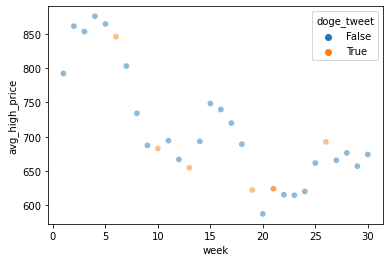

In [113]:
sns.scatterplot( x = 'week',y = 'avg_high_price',data = merge_df_2,hue="doge_tweet", alpha=0.5)
plt.show()

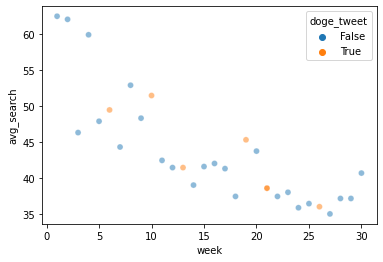

In [114]:
sns.scatterplot( x = 'week',y = 'avg_search',data = merge_df_2,hue="doge_tweet",alpha=0.5)
plt.show()